In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from kmodes.kprototypes import KPrototypes
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
import shap


In [5]:
df2015 = pd.read_csv('20151001hundehalter.csv')
df2016 = pd.read_csv('20160307hundehalter.csv')
df2017 = pd.read_csv('20170308hundehalter.csv')

In [12]:
full = pd.concat([df2015,df2016,df2017]).reset_index(drop=True)
full.head()

,HALTER_ID,ALTER,GESCHLECHT,STADTKREIS,STADTQUARTIER,RASSE1,RASSE1_MISCHLING,RASSE2,RASSE2_MISCHLING,RASSENTYP,GEBURTSJAHR_HUND,GESCHLECHT_HUND,HUNDEFARBE
0,126,51-60,m,9.0,92.0,Welsh Terrier,NaN,NaN,NaN,K,2011,w,schwarz/braun
1,574,61-70,w,2.0,23.0,Cairn Terrier,NaN,NaN,NaN,K,2002,w,brindle
2,695,41-50,m,6.0,63.0,Labrador Retriever,NaN,NaN,NaN,I,2012,w,braun
3,893,61-70,w,7.0,71.0,Mittelschnauzer,NaN,NaN,NaN,I,2010,w,schwarz
4,1177,51-60,m,10.0,102.0,Shih Tzu,NaN,NaN,NaN,K,2011,m,schwarz/weiss


### Column Translations:
ALTER -> Age

GESCHLECHT -> Gender

STADTKREIS -> City Quarter or District

RASSE1 -> Dog's Primary Breed

RASSE2 -> Dog's Secondary Breed

GEBURTSJAHR_HUND -> Dog's Year of Birth

GESCHLECHT_HUND -> Dog's Gender

HUNDEFARBE -> Dog's Color


In [13]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21065 entries, 0 to 21064
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HALTER_ID         21065 non-null  int64  
 1   ALTER             21060 non-null  object 
 2   GESCHLECHT        21065 non-null  object 
 3   STADTKREIS        21060 non-null  float64
 4   STADTQUARTIER     21060 non-null  float64
 5   RASSE1            21065 non-null  object 
 6   RASSE1_MISCHLING  1939 non-null   object 
 7   RASSE2            1590 non-null   object 
 8   RASSE2_MISCHLING  0 non-null      float64
 9   RASSENTYP         20891 non-null  object 
 10  GEBURTSJAHR_HUND  21065 non-null  int64  
 11  GESCHLECHT_HUND   21065 non-null  object 
 12  HUNDEFARBE        21065 non-null  object 
dtypes: float64(3), int64(2), object(8)
memory usage: 2.1+ MB


### Most of the data from `RASSE1_MISCHLING`, `RASSE2`, and `RASSE2_MISCHLING`are missing, so we will drop these columns

In [17]:
data = full.drop(columns=['RASSE1_MISCHLING', 'RASSE2', 'RASSE2_MISCHLING'], axis=1)

### Since the columns are all in German, we will change them to English to make it a bit easier

In [21]:
data.columns = ['ID', 'age', 'gender', 'district','quarter','dog_breed','breed_type','dog_birth_year','dog_gender','dog_color']
data.head()

,ID,age,gender,district,quarter,dog_breed,breed_type,dog_birth_year,dog_gender,dog_color
0,126,51-60,m,9.0,92.0,Welsh Terrier,K,2011,w,schwarz/braun
1,574,61-70,w,2.0,23.0,Cairn Terrier,K,2002,w,brindle
2,695,41-50,m,6.0,63.0,Labrador Retriever,I,2012,w,braun
3,893,61-70,w,7.0,71.0,Mittelschnauzer,I,2010,w,schwarz
4,1177,51-60,m,10.0,102.0,Shih Tzu,K,2011,m,schwarz/weiss


### Checking for missing values

In [28]:
data.isna().sum()

ID                  0
age                 5
gender              0
district            5
quarter             5
dog_breed           0
breed_type        174
dog_birth_year      0
dog_gender          0
dog_color           0
dtype: int64

In [30]:
data = data.dropna()

In [87]:
features = data.drop('ID', axis=1)
features = features.reset_index(drop=True)

### There are 4 rows with an incorrect `dog_birth_year`, we will drop them:

In [88]:
rows_to_drop = list(features.query('dog_birth_year == 5012 or dog_birth_year == 1 or dog_birth_year == 8').index)
features.iloc[rows_to_drop]

,age,gender,district,quarter,dog_breed,breed_type,dog_birth_year,dog_gender,dog_color
2815,41-50,w,2.0,24.0,Labrador Retriever,I,8,w,braun
3077,71-80,w,11.0,119.0,Labrador Retriever,I,1,w,schwarz
4419,41-50,w,3.0,34.0,Parson Russell Terrier,K,5012,m,tricolor
11116,51-60,w,3.0,34.0,Parson Russell Terrier,K,5012,m,tricolor


In [89]:
features = features.drop(rows_to_drop).reset_index(drop=True)

### Normalizing Numerical Columns

In [90]:
from sklearn.preprocessing import MinMaxScaler
features_norm = features.copy()
scaler = MinMaxScaler()
features_norm[['district', 'quarter','dog_birth_year']] = scaler.fit_transform(features_norm[['district', 'quarter','dog_birth_year']])

In [91]:
features_norm

,age,gender,district,quarter,dog_breed,breed_type,dog_birth_year,dog_gender,dog_color
0,51-60,m,0.727273,0.739496,Welsh Terrier,K,0.890909,w,schwarz/braun
1,61-70,w,0.090909,0.159664,Cairn Terrier,K,0.727273,w,brindle
2,41-50,m,0.454545,0.495798,Labrador Retriever,I,0.909091,w,braun
3,61-70,w,0.545455,0.563025,Mittelschnauzer,I,0.872727,w,schwarz
4,51-60,m,0.818182,0.823529,Shih Tzu,K,0.890909,m,schwarz/weiss
...,...,...,...,...,...,...,...,...,...
20875,31-40,m,0.727273,0.731092,Mischling gross,I,0.963636,w,golden
20876,31-40,w,0.545455,0.588235,Boxer,I,0.981818,w,gelb/weiss
20877,11-20,w,0.909091,0.899160,Pinscher,K,0.981818,w,schwarz
20878,31-40,w,0.545455,0.571429,Whippet,I,0.981818,w,vierfarbig


In [92]:
features_norm['age'].value_counts()

51-60     4534
41-50     4435
31-40     3916
61-70     3058
21-30     2324
71-80     1938
81-90      505
11-20      126
91-100      44
Name: age, dtype: int64

In [ ]:
kproto = KPrototypes(n_clusters=9, init='Cao')
clusters = kproto.fit_predict(features_norm, categorical=[0,1,4,5,7,8])
 
labels = pd.DataFrame(clusters)
labeled_features = pd.concat((features,labels),axis=1)
labeled_features = labeled_features.rename({0:'labels'},axis=1)


In [96]:
labeled_features

,age,gender,district,quarter,dog_breed,breed_type,dog_birth_year,dog_gender,dog_color,labels
0,51-60,m,9.0,92.0,Welsh Terrier,K,2011,w,schwarz/braun,7
1,61-70,w,2.0,23.0,Cairn Terrier,K,2002,w,brindle,0
2,41-50,m,6.0,63.0,Labrador Retriever,I,2012,w,braun,4
3,61-70,w,7.0,71.0,Mittelschnauzer,I,2010,w,schwarz,4
4,51-60,m,10.0,102.0,Shih Tzu,K,2011,m,schwarz/weiss,8
...,...,...,...,...,...,...,...,...,...,...
20875,31-40,m,9.0,91.0,Mischling gross,I,2015,w,golden,4
20876,31-40,w,7.0,74.0,Boxer,I,2016,w,gelb/weiss,4
20877,11-20,w,11.0,111.0,Pinscher,K,2016,w,schwarz,5
20878,31-40,w,7.0,72.0,Whippet,I,2016,w,vierfarbig,4


In [106]:
X = labeled_features.drop('labels', axis=1)
y = labeled_features['labels']

In [108]:
X = pd.get_dummies(X)

In [113]:
clf_kp = LGBMClassifier()
cv_scores_kp = cross_val_score(clf_kp, X, y, scoring='f1_weighted', cv=5)
print(f'CV F1 score for K-Prototypes clusters is {np.mean(cv_scores_kp)}')

CV F1 score for K-Prototypes clusters is 0.9967418724031244


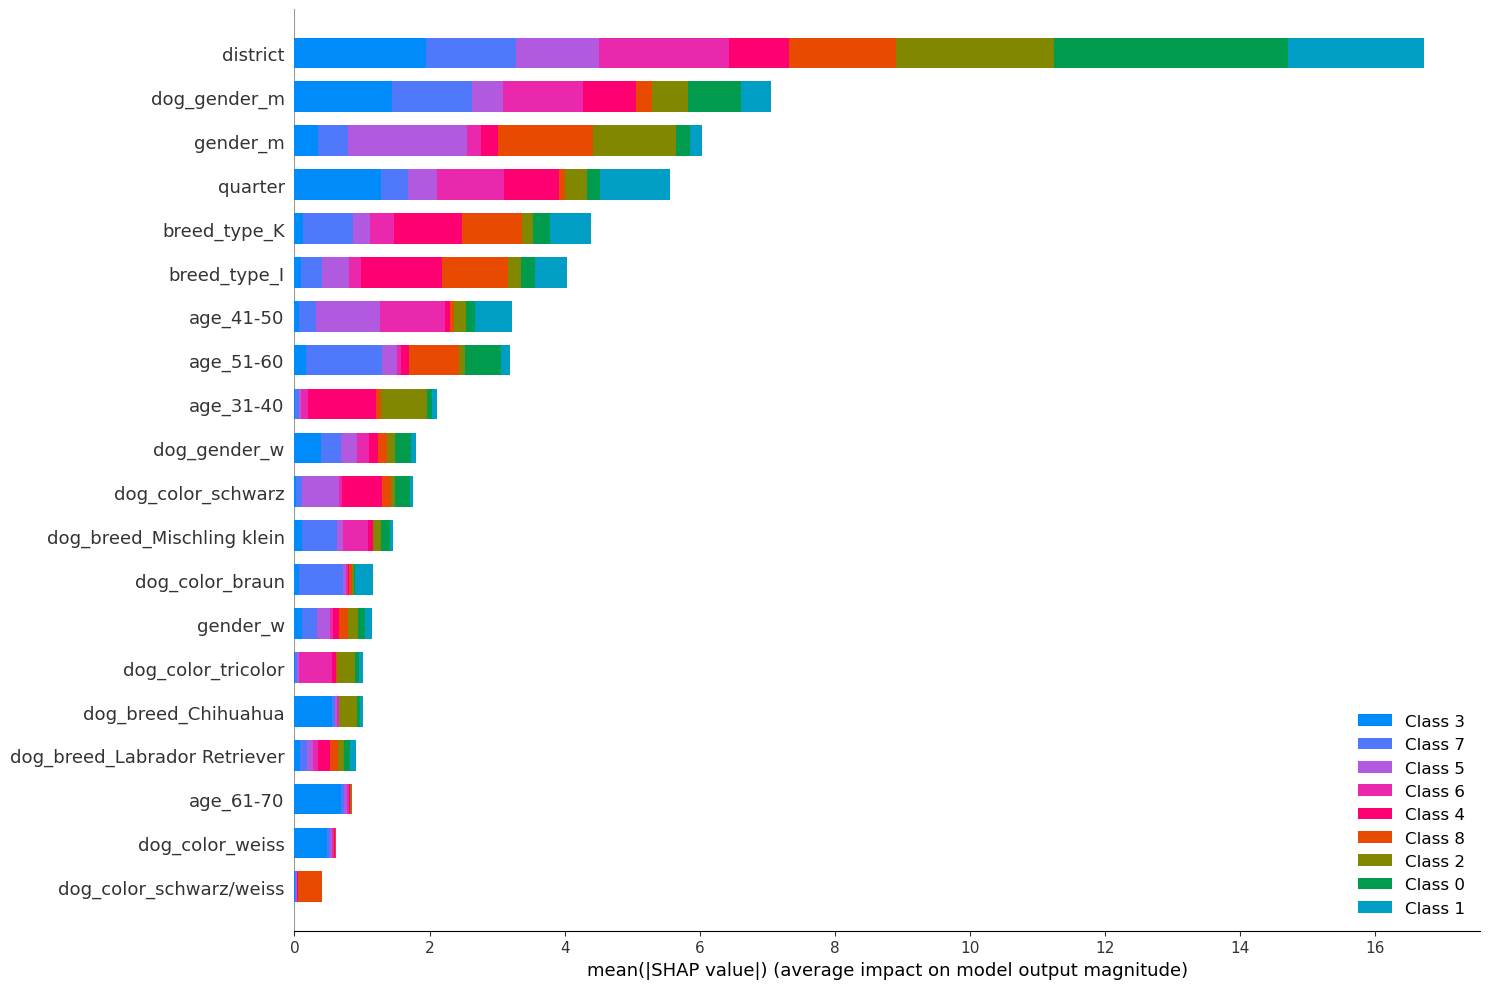

In [115]:
clf_kp.fit(X, y)
explainer_kp = shap.TreeExplainer(clf_kp)
shap_values_kp = explainer_kp.shap_values(X)
shap.summary_plot(shap_values_kp, X, plot_type="bar", plot_size=(15, 10))

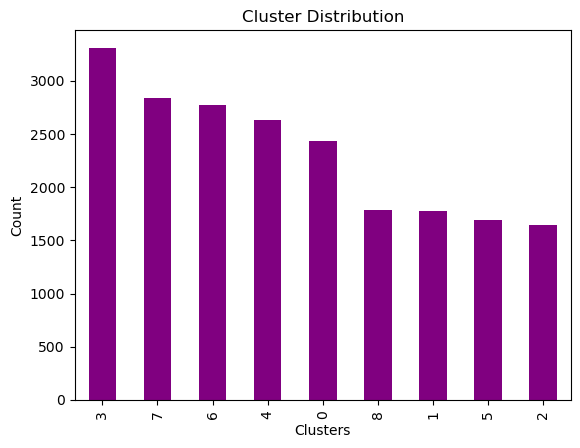

In [124]:
labeled_features['labels'].value_counts().plot(kind='bar', color='purple')
plt.xlabel('Clusters')
plt.ylabel('Count')
plt.title('Cluster Distribution')
plt.show()

In [117]:
labeled_features.groupby('labels').agg(lambda x: pd.Series.mode(x).iat[0])[['age','gender','dog_breed','breed_type','dog_gender','dog_color']]

,age,gender,dog_breed,breed_type,dog_gender,dog_color
labels,,,,,,
0,51-60,w,Mischling klein,K,w,schwarz
1,41-50,w,Labrador Retriever,I,m,braun
2,31-40,m,Chihuahua,K,m,tricolor
3,61-70,w,Chihuahua,K,m,weiss
4,31-40,w,Labrador Retriever,I,w,schwarz
5,41-50,m,Jack Russel Terrier,K,w,schwarz
6,41-50,w,Mischling klein,K,m,tricolor
7,51-60,w,Mischling klein,K,w,braun
8,51-60,m,Labrador Retriever,I,w,schwarz/weiss


In [119]:
labeled_features.groupby('age').agg(lambda x: pd.Series.mode(x).iat[0])[['dog_breed']]

,dog_breed
age,
11-20,Chihuahua
21-30,Chihuahua
31-40,Chihuahua
41-50,Mischling klein
51-60,Mischling klein
61-70,Mischling klein
71-80,Mischling klein
81-90,Mischling klein
91-100,Mischling klein


# Cluster Results:

Clusters 0,7, and 8: People aged 51-60 generally prefer the Mischling Klein and Labrador Retriever

Clusters 1,5,and 6 : People aged 41-50 also prefer Mischling Klein and Labrador Retriever but also Jack Russel Terrier

Clusters 2 and 4: People aged 31-40 prefer the Chihuahua and Labrador Retriever

Cluster 3: People aged 61-70 prefer the Chihuahua

# Most Common Dog Breeds by Age

Ages 11-40: Chihuahua

Ages 41-100 Mischling klein

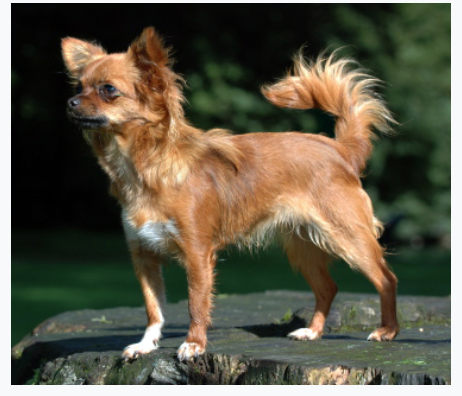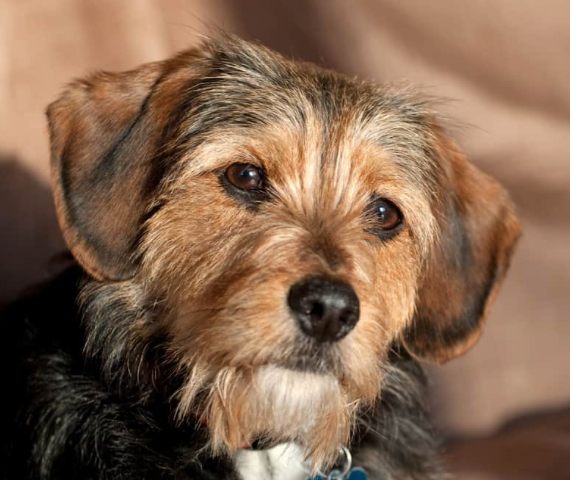